**Goal** - In this notebook, I will demonstrate the Machine Learning Project workflow for Classification. I have picked a customer churn dataset available on IBM sample Data Sets for this exercise. (https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) 

**Business Problem** - 
A fictional telco company provides home phone and Internet services to 7043 customers in California. We have customer churn data indicating which customers left, stayed or signedup for their services in the last month. Demographics and etc data is also vailable for each customer. 

We want to explore this data set to understand what impacts customer churn and develop a predictive model to identify customer's liklihood to churn.
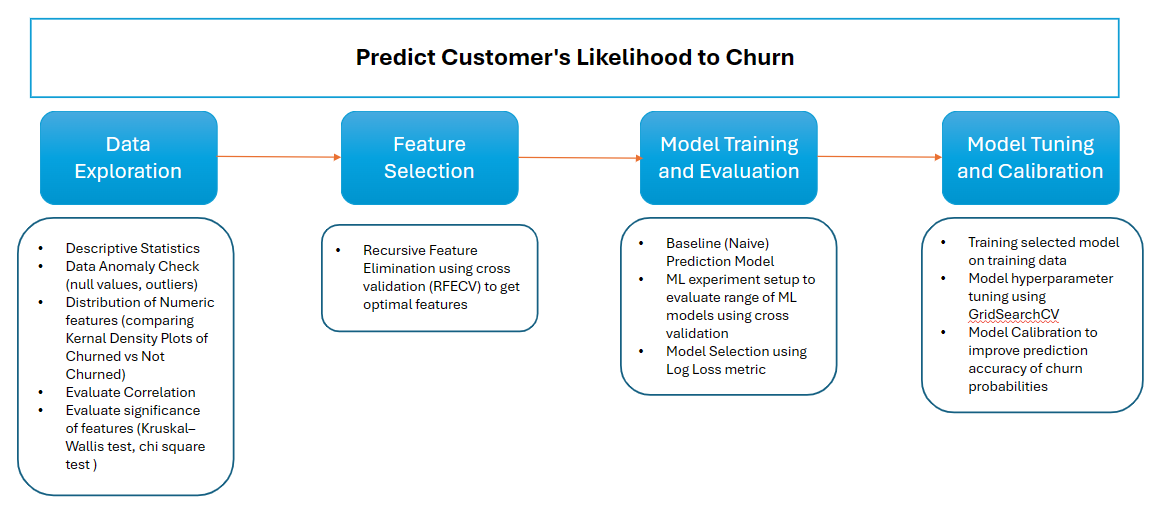


# Import Python Libraries 

In [1]:
#import python libraries 
import pandas as pd
import numpy as np
import sklearn.metrics as m 
from sklearn.metrics import  roc_curve , auc , confusion_matrix, log_loss, brier_score_loss, f1_score

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import sklearn.model_selection as cv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  roc_curve , auc , confusion_matrix 

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_selection import RFECV, RFE

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, precision_score, recall_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve

import warnings

# Mute all warnings
warnings.filterwarnings("ignore")


# Ingest Data

In [2]:
#Read data in pandas dataframe 
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#get a sense of the data 
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#identify the number of records and features/columns in this data set 
print(f'The number of records are {df.shape[0]}')
print(f'The number of features inluding the churn predictor variable are {df.shape[1]}')


The number of records are 7043
The number of features inluding the churn predictor variable are 21


# Perform Exploratory Data Analysis (EDA)

**Check for Null values. Calculate the Churn Rate**

In [4]:
#explore the dependent variable 'Churn'

#check if there are any null values for 'Churn' 
print(f"number of records with null values for Churn are {df['Churn'].isnull().sum()}") 

# we want to see the distribution of customers for distinct Churn values 

print(df.groupby('Churn')['customerID'].count())

#Note - here Yes means customer has churned/ left the company while No means the customer stayed 

#Convert Chrun to binary variable such that Yes = 1 and No = 0. This is the target variable 
# we want to predict liklihood of churn hence we will map Yes to 1 for future classification model 

df['Churn_Target'] = df['Churn'].map({'Yes': 1, 'No': 0})

#calculate churn rate i.e. number of customer churned/ total customers 

print(f"Churn rate is {sum(df['Churn_Target'])*100/ len(df['Churn_Target'])}")



number of records with null values for Churn are 0
Churn
No     5174
Yes    1869
Name: customerID, dtype: int64
Churn rate is 26.536987079369588


In [5]:
#check if there are null values in the data  

null_vals = df.isnull().sum()

print(f'columns with null values: {null_vals[null_vals > 0]}')
#No null values 


columns with null values: Series([], dtype: int64)


**check descriptive statistics of the data **

In [6]:

df.describe() 
#OBSERVATIONS  
# - We had total 21 features but we are seeing descriptive stats of only few. Other features are categorical. 
# - The SeniorCitien feature is binary 
# - In Cell 6, we saw 5 rows from the data which included TotalCharges feature.
#         It is numeric variable but we cannot see it in  describe output below
# - Let us investigate it 

,SeniorCitizen,tenure,MonthlyCharges,Churn_Target
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [7]:
print(f"data type of TotalCharges is {df['TotalCharges'].dtype}")

#convert object to float 
# df['TotalCharges'] = df['TotalCharges'].astype(float) -- commented as I get error - could not convert string to float

#There can be blank values which should be converted to NaN first 
#By using pd.to_numeric with errors='coerce', any non-numeric values (including empty strings) will be replaced with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.describe()


data type of TotalCharges is object


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Target
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370
std,0.368612,24.559481,30.090047,2266.771362,0.441561
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


**Plot the distribution of the numeric predictors**

This is cruicial to identify extreame  skewness in any of these features 
This helps in deciding if we should use the mean or median (in case of skewed data) values to impute missing values. 

ML algorithims that have normalization assumption e.g. Linear Regression, KNN are sensitive to skewed data hence transformation like logarithmic, square root, cube root, and Box-Cox transformations will improve model performance 

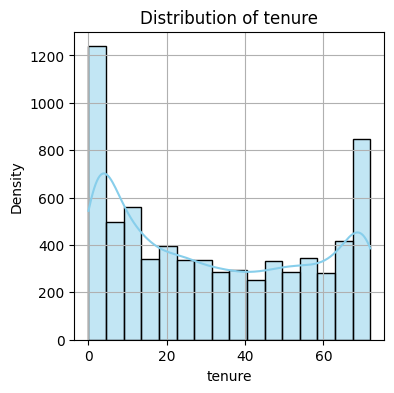

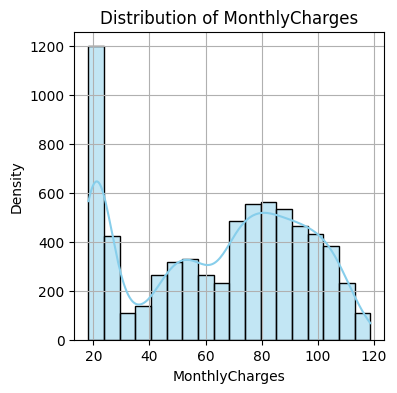

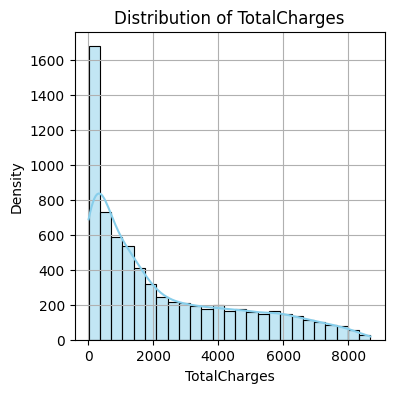

In [8]:
list_numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] 

#plot distribution of numeric variables
for col in list_numeric_features:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(4, 4))
        sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()



**Observation**

- total charges is right skewed. majority of customer have total charges between 18 (minimum value as seen in summary statistics results earlier) to 2000


- distribution of tenure represents a bimodal curve as it has 2 peaks at the extremes


**Check for outliears**

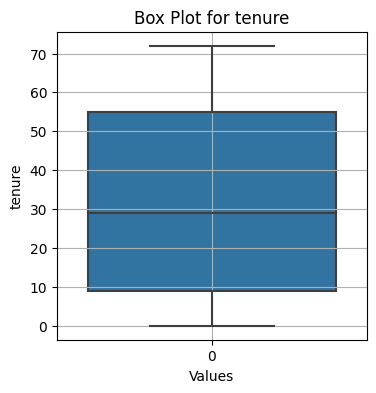

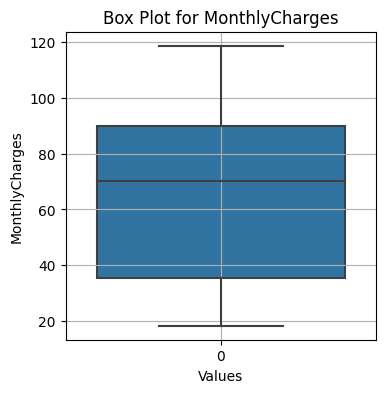

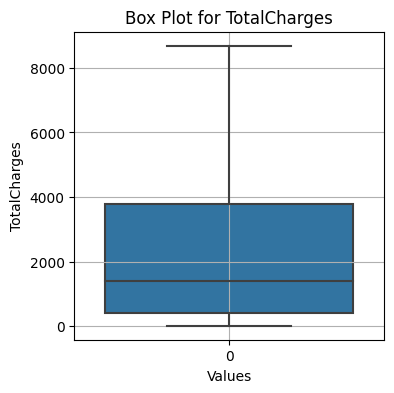

In [9]:
#check for outliers 
#outlier detection 
for col in list_numeric_features:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df[col])
    plt.title(f'Box Plot for {col}')
    plt.xlabel('Values')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

#OBSERVATION - No outliers in the data 

**Explore numeric features and their relationship with the outcome - Churn**

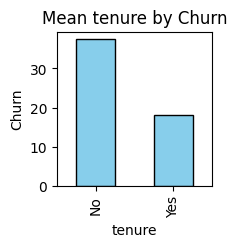

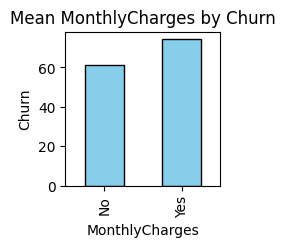

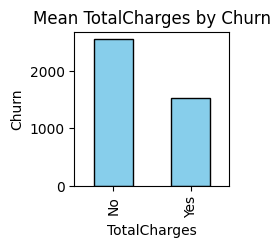

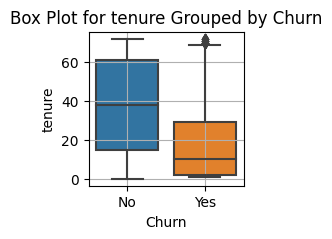

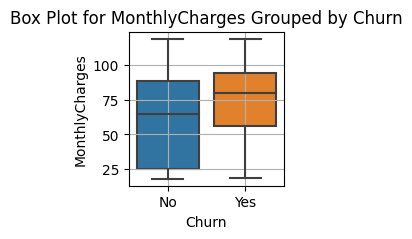

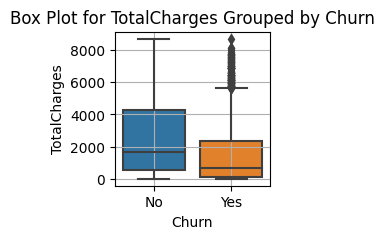

In [10]:
 

# compare mean of those who churn vs those who don't 
for col in list_numeric_features:
    plt.figure(figsize=(2,2))
    group_mean = df.groupby('Churn')[col].mean()
    group_mean.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Churn')
    plt.title(f'Mean {col} by Churn')
    plt.show()

#Compare the mean values of numeric features for customer who churned vs who did not 
for col in list_numeric_features:
    plt.figure(figsize=(2,2))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Box Plot for {col} Grouped by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()
    



**Observation**

  - Average tenure of those who churn is very low compared to that of customers who stayed
    - This suggestss that churn likely happens in  early stage of customer journey 
     - Median tenure of those who churn is only 10 months compared to median tenure of 40 months of those who stayed 
  - Monthly charges of those who churn are higher than that of customers who stayed 
  - Total charges are higher for those who stayed


**Compare the Kernal Density plots of  these numeric variables for customers who chrun vs who don't.**

KDE plots will help us evaluate where the data is most concentrated in each category and help in 
visually identifying if there is good enough variability in distribution of these numeric features making them a good predictor. 


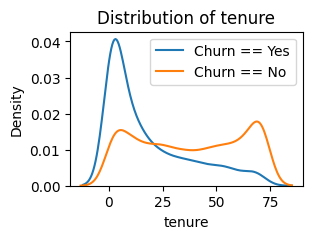

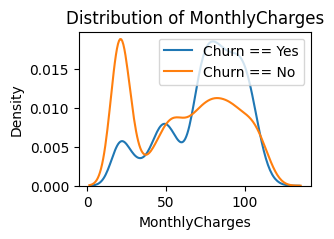

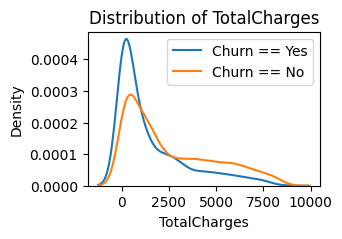

In [11]:
for col in list_numeric_features:
    plt.figure(figsize=(3, 2))

    # KDE plot of loans that were repaid on time
    sns.kdeplot(df.loc[df['Churn'] == 'Yes', col], label='Churn == Yes')
    sns.kdeplot(df.loc[df['Churn'] == 'No', col], label='Churn == No')

    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'Distribution of {col}')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

**Observation** 

- The KDE plot of churned vs not churned customers shows variability in distribution for all three numeric variables 
- This means these variables can be good indicators of likelihood of churn 
- We need to now understand the intercorralation among these predictors 

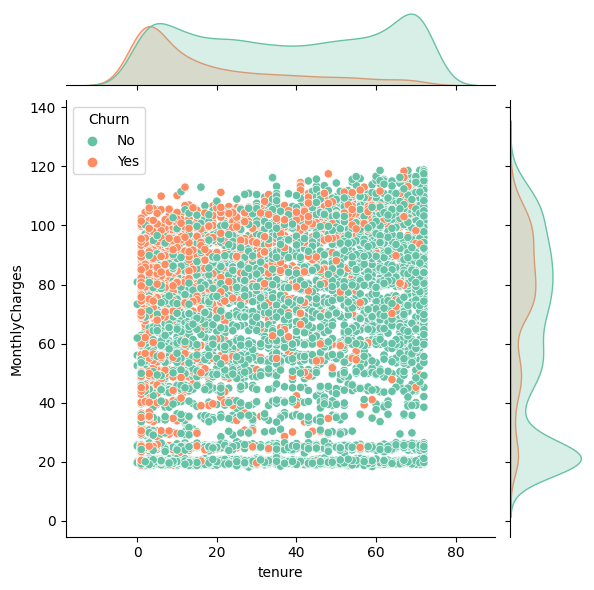

In [12]:
sns.jointplot(data=df, x='tenure', y='MonthlyCharges', palette='Set2', hue='Churn')
plt.show()

**Correlation matrix to check for itercorrelation/ interactions among numeric predictors**

Total Charges is highly correlated with Tenure and Monthly Charges. 
Essentially total charges = Tenure * Monthly Charges 
So to avoid multi-collinarity issues we will exclude Total Charges for building the predictive model

Variable correlation


Text(0.5, 1.05, 'Pearson correlation of Features')

<Figure size 200x200 with 0 Axes>

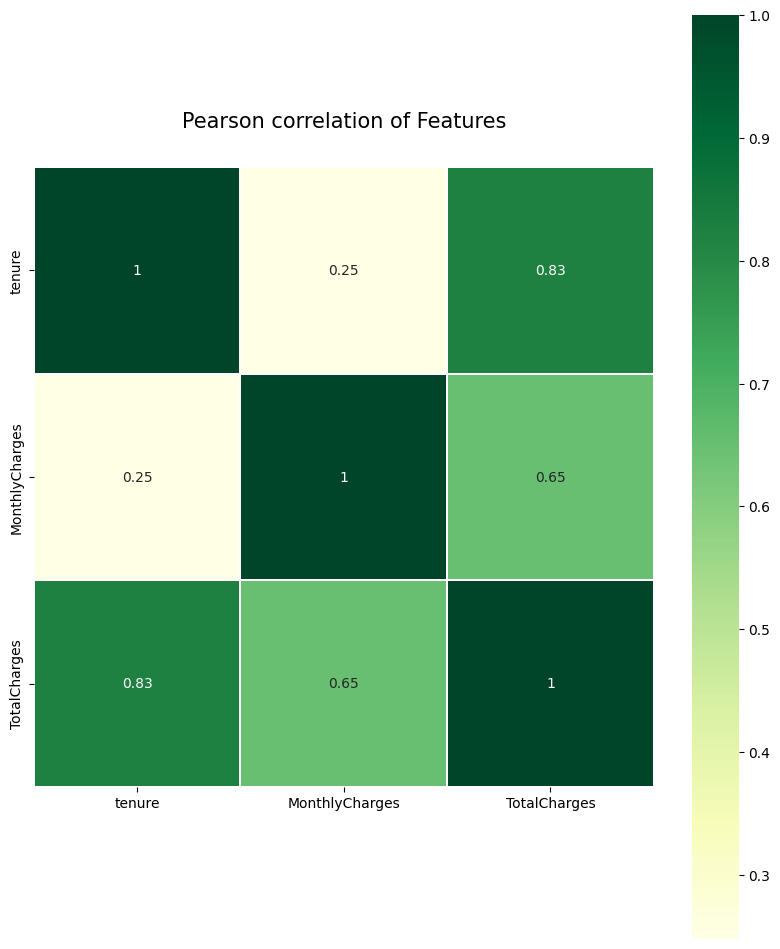

In [13]:
# evaluate correlation among independent numericx variables 
print('Variable correlation')
plt.figure(figsize=(2, 2))

%matplotlib inline
corr = df[list_numeric_features].corr()

f, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

We want to do filter based feature selection by testing the relation between churn (category) and the numeric variables 
- ANOVA can be used to check relation between category and numeric variables - if will tell us if the mean of the numeric variables
differs significantly among groups. But the assumption is that the numeric variable follows normal distribution. 
This is not the case here so cannot use ANOVA 

- Non parametric alternative -  Kruskal–Wallis test - used to determine whether or not there is a statistically significant difference between the medians of three or more independent groups.

- one way is to log transform monthly charges to get normal distribution and then run anova 

to check difference in distributin mannwhitneyu test also known as  Wilcoxon rank-sum test

In [14]:
# Kruskal–Wallis test 
from scipy.stats import kruskal
sig_num_vars = []
for col in list_numeric_features:
    groups = df.groupby('Churn')[col].apply(list).values
    stat, p_value = kruskal(*groups)
    print(f'Kruskal-Wallis H test statistic: {stat}, p-value: {p_value}')
    if p_value <= 0.05:
     sig_num_vars.append(col)

    
    

Kruskal-Wallis H test statistic: 948.7996915155916, p-value: 2.4191401818659714e-208
Kruskal-Wallis H test statistic: 240.34263218324136, p-value: 3.3112855487838454e-54
Kruskal-Wallis H test statistic: nan, p-value: nan


In [15]:
sig_num_vars

['tenure', 'MonthlyCharges']

**Exploring Categorical Features** 

- We will look at how the chrun rate differs across categories 
- We will also run Chi square test of independence to identify categorical variables that have signifiant relation with the Chrun category we want to predict. 


In [16]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Target
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [17]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')
print(f"data type of TotalCharges is {df['SeniorCitizen'].dtype}")

data type of TotalCharges is object


In [18]:
#list the categorical features, check how many distinct values each category has 
cat_vars = df.select_dtypes(include=['O']).columns.tolist()
print(f'number categorical features: {len(cat_vars)}')
#The 'Churn' response variable is removed for the cat_vars list 
cat_vars.remove('Churn')
print(df[cat_vars].nunique())
#remove customer ID from the list 
cat_vars.remove('customerID')

number categorical features: 18
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
dtype: int64


In [19]:
#running the chi square test 

# Loop through each categorical feature and identify those that are significant 
sig_cat_vars = []
for col in cat_vars:
    
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['Churn'])
        
    # Perform chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
        
    # print(f"Chi-square p-value for {col}: {p}")
    if p <= 0.05:
     sig_cat_vars.append(col)
print(len(sig_cat_vars))
print(sig_cat_vars)

14
['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


- Of the 16 categorical variables, 13 have significant relation with the Chrun category we want to predict
- Let us further look at the churn rate for each of these categories 


Axes(0.125,0.11;0.775x0.77)


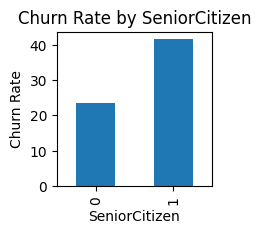

Axes(0.125,0.11;0.775x0.77)


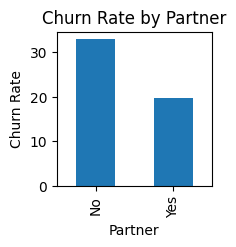

Axes(0.125,0.11;0.775x0.77)


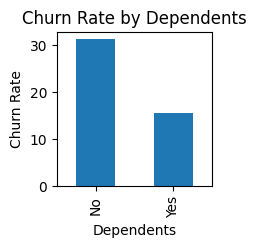

Axes(0.125,0.11;0.775x0.77)


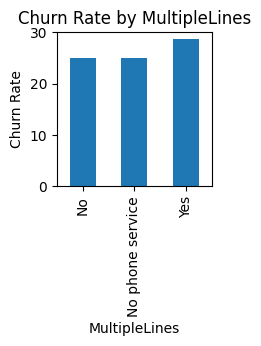

Axes(0.125,0.11;0.775x0.77)


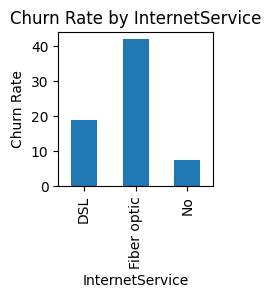

Axes(0.125,0.11;0.775x0.77)


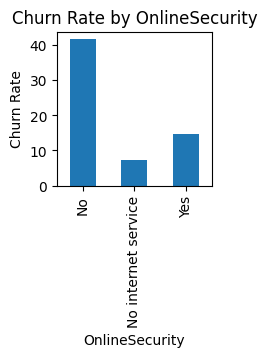

Axes(0.125,0.11;0.775x0.77)


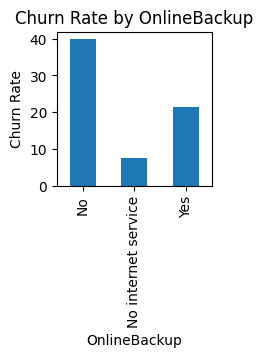

Axes(0.125,0.11;0.775x0.77)


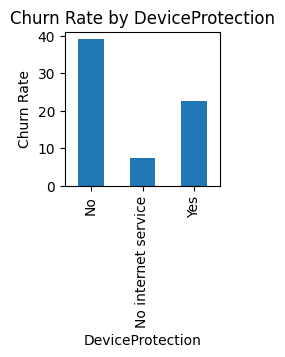

Axes(0.125,0.11;0.775x0.77)


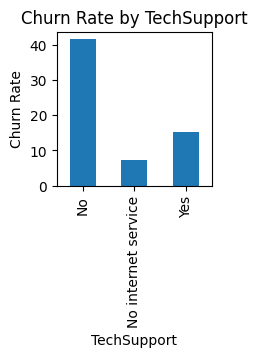

Axes(0.125,0.11;0.775x0.77)


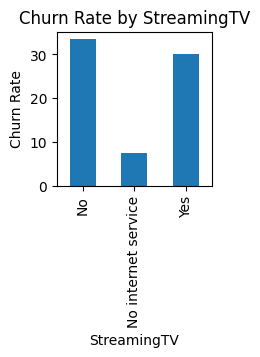

Axes(0.125,0.11;0.775x0.77)


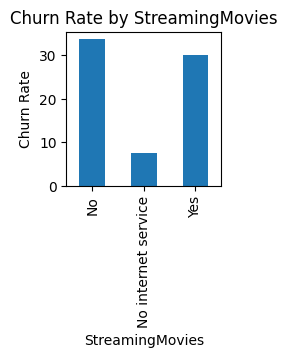

Axes(0.125,0.11;0.775x0.77)


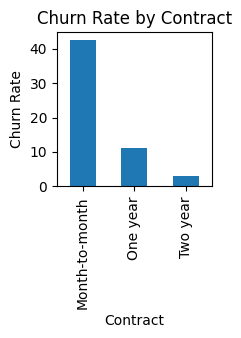

Axes(0.125,0.11;0.775x0.77)


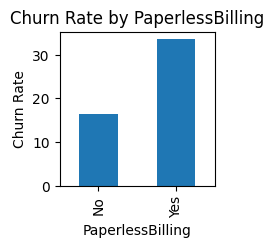

Axes(0.125,0.11;0.775x0.77)


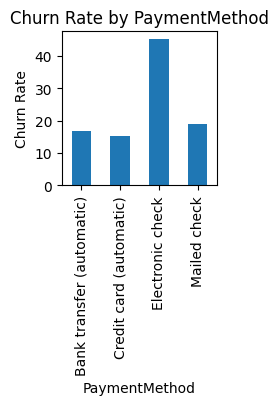

In [20]:
# Plot the risk % by various categorical variables 
for col in sig_cat_vars: 
    plt.figure(figsize=(2, 2))
    risk_pct = df.groupby(col).apply(lambda x: x['Churn_Target'].sum() * 100/ len(x['Churn_Target']))
#     print(f'% of customers at risk by {col}')
    print(risk_pct.plot.bar())
    # Set title and labels
    plt.title('Churn Rate by ' + col)  # Set the title
    plt.xlabel(col)  # Set the label for the x-axis
    plt.ylabel('Churn Rate')  # Set the label for the y-axis

    # Show the plot
    plt.show()

**Observation**

- The churn rate is high among senior citizens
- churn rate is higher among those who don't have partners or dependents 
- customers will multiple lines or those with fiber optic connection type have higher churn rate 
- those who don't have online security, online backup, tech support or online device protection have higher churn rate 
- churn rate is lower among those who do not have streaming TV or Movies
- Those with month - to - month contract have higher churn rate 
- online savy customers who have paperless billing and pay through electronic checks have higher churn rate 


# Feature Selection 

- Step 1: Split data in Train (80%) and Test (20%) sets. We want to do feature selection based on Training set to avoid data leakage 

- Step 2: Create data pipeline with steps for feature transformation (One Hot Encoding and Standard Scalar) and RFECV (Recurrsive Feature Elimination CV) using Random Forest Classifier. Since we have imbalanced class we will use F1 score for scoring 

- Fit this pipeline on training data and get the optimal features. Cross check with the list of features having significant relation with target. 
  We executed the significance tests and identified significant numeric and categorical features in data exploration phase. 


In [21]:
df.shape

(7043, 22)

In [22]:
# Define features and target
X = df.drop(['Churn_Target','customerID', 'Churn'], axis=1)
y = df['Churn_Target']
# X.head()

#Split data in Train 80%  and Test 20% groups using stratified split on target .
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

categorical_preprocessor = OneHotEncoder(drop='first', handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

categorical_vars = X.select_dtypes(include=['O']).columns.tolist()

# numeric_vars = X.select_dtypes(np.number).columns.tolist()


FS_preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_vars),
        ("standard-scaler", numerical_preprocessor, sig_num_vars)
    ]
)

rf = RandomForestClassifier(n_estimators = 1000, min_samples_leaf =10, random_state = 42)

cv = StratifiedKFold(n_splits=3)

# Recurcive feature elimination with cross validation 
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv= cv,
    min_features_to_select = 1,
    scoring='neg_log_loss',
    n_jobs=-1
)




In [23]:
# evaluate the random forest feature importance executed on entire training data 
fs_model_pipeline_rf = Pipeline(steps=[
    ('preprocessor', FS_preprocessor),
    ('classifier', rf)
])


fs_model_pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=10, n_estimators=1000,
                                        random_state=42))])

In [24]:

fs_model_pipeline = Pipeline(steps=[
    ('preprocessor', FS_preprocessor),
    ('classifier', rfecv)
])


fs_model_pipeline.fit(X_train, y_train)
print("Optimal number of features: %d" % rfecv.n_features_)



Optimal number of features: 13


In [25]:
# preprocessor.fit(X_train)
feature_names = fs_model_pipeline.named_steps['preprocessor'].get_feature_names_out()

best_features = feature_names[rfecv.support_].tolist()
print("Total Features:", feature_names.shape)

print("Best Features: %s" % len(best_features))

print("Best Features List: %s" % best_features)


# -- in RFECV first random forest algo is applied on entire data. In this case training data. The feature importance is calculated
# -- then each least imp feature is removed one at a time. Random forest is executed on remaining features in cross validation - the value of evaluation metric is recorded
# - this goes on until no features are left to remove 
# the set of features which gave optimal result for evaluation metric are selected 
# - can we do a nested cross val for more robut feature selection where in feature selection is done on each of the fold and RFECV is applied to that fold. 


Total Features: (29,)
Best Features: 13
Best Features List: ['one-hot-encoder__InternetService_Fiber optic', 'one-hot-encoder__InternetService_No', 'one-hot-encoder__OnlineSecurity_Yes', 'one-hot-encoder__OnlineBackup_Yes', 'one-hot-encoder__TechSupport_Yes', 'one-hot-encoder__StreamingTV_No internet service', 'one-hot-encoder__StreamingMovies_No internet service', 'one-hot-encoder__Contract_One year', 'one-hot-encoder__Contract_Two year', 'one-hot-encoder__PaperlessBilling_Yes', 'one-hot-encoder__PaymentMethod_Electronic check', 'standard-scaler__tenure', 'standard-scaler__MonthlyCharges']


In [26]:
df.groupby('gender').nunique()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Target
gender,,,,,,,,,,,,,,,,,,,,,
Female,3488,2,2,2,73,2,3,3,3,3,...,3,3,3,3,2,4,1270,3344,2,2
Male,3555,2,2,2,73,2,3,3,3,3,...,3,3,3,3,2,4,1286,3375,2,2


# ML Model Build and Evaluate (Run ML Experiment)

- Among all features those that are best features as per RFECV are used further to develop ML Models
- Create function to train and evaluate model. Models are training only on the training data using 4 fold cross validation 
- define list of models to experiment and loop through the list, calling above function in each iteration 
- store results of all model experiments in data frame 

Note - we will run logistic regression, Random Forest, Random Forest with class weight balanced, XGBoost and NN. 
Models will be evaluated for 2 different prediction goals 

    - Predict the class where output is whether someone will churn or not. For this models are scored using ROC_AUC and F1 Score 
    
    - Predict the liklihood of churn where the output is probability of churn (0 to 1). For this models are scored using Log loss
    
    **The optimal model differs based on whether we want to predict class or probability of being in a class 


**Function to run ML experiments**

In [27]:

def ml_model_run(X_train, X_test, Y_train, Y_test, ml_model, ml_model_desc, cv, score):
    
    cv_scores = cross_validate(ml_model, X_train, Y_train, cv=cv, scoring = score,  return_train_score=True)

    mean_scores = {}
    for s in score: 
        mean_scores[f'mean_train_{s}'] = np.mean(cv_scores[f'train_{s}'])
        mean_scores[f'mean_test_{s}'] = np.mean(cv_scores[f'test_{s}'])
       
    
    result = [ml_model_desc,ml_model.get_params(),score,mean_scores]
    
    
    return result
    



**Baseline model with all features**

In [28]:
#Further use features selected from RFE CV for model building 
FS_preprocessor.fit(X_train)

X_train_ohe = pd.DataFrame(FS_preprocessor.transform(X_train),columns=FS_preprocessor.get_feature_names_out())
X_test_ohe = pd.DataFrame(FS_preprocessor.transform(X_test),columns=FS_preprocessor.get_feature_names_out())

X_train_fs = X_train_ohe[best_features]
X_test_fs = X_test_ohe[best_features]

print(X_train_ohe.shape)
print(X_train_fs.shape)

(5634, 29)
(5634, 13)


In [29]:

from sklearn.dummy import DummyClassifier

rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf =4, random_state = 42)
rf_balanced = RandomForestClassifier(n_estimators = 100, min_samples_leaf =4, random_state = 42, class_weight='balanced')
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
log_reg = LogisticRegression()
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
clf_dummy = DummyClassifier(random_state=42, strategy = 'most_frequent') 

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

score = ['roc_auc', 'recall', 'f1', 'neg_log_loss']
# metric = m.roc_auc_score
model_list = {'Baseline Predicting most frequest class':  clf_dummy,
    'Random Forest': rf, 
    'Random Forest - Class wt balanced': rf_balanced, 
              'XGBoost': xgb_classifier,
              'Logistic' : log_reg,
              'nn' : nn
             }
ml_expriments_df = pd.DataFrame(columns = ['model_name', 'config', 'metric', 'cv_score']) 

#baseline model training on 29 features 

# baseline probabilities -- predicting the most frequent class that is 0 in this case 
probabilities = [0 for _ in range(len(y_test))]
avg_brier = brier_score_loss(y_test, probabilities)
avg_log_loss = log_loss(y_test, probabilities)
print('Baseline: Brier Score=%.4f' % (avg_brier))
print('Baseline: log_loss=%.4f' % (avg_log_loss))
print('Baseline: F1=%.4f' % (f1_score(y_test, probabilities)))

# probabilities = [0.265 for _ in range(len(y_test))]
# avg_brier = brier_score_loss(y_test, probabilities)
# avg_log_loss = log_loss(y_test, probabilities)
# print('Baseline: Brier Score=%.4f' % (avg_brier))
# print('Baseline: log_loss=%.4f' % (avg_log_loss))
# # print('Baseline: F1=%.4f' % (f1_score(y_test, probabilities)))

# result = ml_model_run(X_train_ohe, X_test_ohe, y_train, y_test, log_reg, 'Baseline Logistic all features', cv, score)
# ml_expriments_df.loc[len(ml_expriments_df)] = result

#ML models on selected 13 features



for k,v in model_list.items(): 
    result = ml_model_run(X_train_fs, X_test_fs, y_train, y_test, v, k, cv, score)
    ml_expriments_df.loc[len(ml_expriments_df)] = result
   
ml_expriments_df

Baseline: Brier Score=0.2654
Baseline: log_loss=9.5673
Baseline: F1=0.0000


,model_name,config,metric,cv_score
0,Baseline Predicting most frequest class,"{'constant': None, 'random_state': 42, 'strate...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.5, 'mean_test_roc_auc..."
1,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.9360878230183852, 'me..."
2,Random Forest - Class wt balanced,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.9379777893856737, 'me..."
3,XGBoost,"{'objective': 'binary:logistic', 'base_score':...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.9763242602040204, 'me..."
4,Logistic,"{'C': 1.0, 'class_weight': None, 'dual': False...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.845394633783136, 'mea..."
5,nn,"{'activation': 'relu', 'alpha': 0.0001, 'batch...","[roc_auc, recall, f1, neg_log_loss]","{'mean_train_roc_auc': 0.8535408375167425, 'me..."


In [30]:
df_fixed = ml_expriments_df.join(pd.json_normalize(ml_expriments_df['cv_score'])).drop('cv_score', axis='columns')
df_fixed

,model_name,config,metric,mean_train_roc_auc,mean_test_roc_auc,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_neg_log_loss,mean_test_neg_log_loss
0,Baseline Predicting most frequest class,"{'constant': None, 'random_state': 42, 'strate...","[roc_auc, recall, f1, neg_log_loss]",0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,-9.564299,-9.564299
1,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[roc_auc, recall, f1, neg_log_loss]",0.936088,0.842277,0.642141,0.504322,0.713369,0.567157,-0.308484,-0.431672
2,Random Forest - Class wt balanced,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","[roc_auc, recall, f1, neg_log_loss]",0.937978,0.842272,0.869564,0.720385,0.751531,0.628251,-0.337572,-0.456508
3,XGBoost,"{'objective': 'binary:logistic', 'base_score':...","[roc_auc, recall, f1, neg_log_loss]",0.976324,0.820246,0.811706,0.492954,0.844017,0.535482,-0.217464,-0.474353
4,Logistic,"{'C': 1.0, 'class_weight': None, 'dual': False...","[roc_auc, recall, f1, neg_log_loss]",0.845395,0.842509,0.534448,0.534421,0.587006,0.586122,-0.416354,-0.419831
5,nn,"{'activation': 'relu', 'alpha': 0.0001, 'batch...","[roc_auc, recall, f1, neg_log_loss]",0.853541,0.842932,0.555852,0.547122,0.603582,0.590637,-0.406352,-0.419628


# Model evaluation

- Predicting class 
Based on the F1 score of the test fold of Cross Valudation, Random Forest with Class weight Balanced parameter is the best performaing model. Since the score for training folds is higher here it means there is an overfitting problem. To address this issue we can explore hyperparameter runing like decreasing tree depth, increasing n_estimators (number of trees), evaluate the feature importance of this model and test model outcome on selecting top n features using CV, since this is imbalanced class we can increase data size by creating 50-50 distribution of each class or suing SMOTE. 

- Predicting Class probability 
Based on the neg_log_loss of the test fold of Cross Valudation, Neural Network with 1 hidden layer of 10 neurons performs best. In this notebook, we aim to predict class probability so as next steps we will train this model on entire training data and evaluate the log loss, we will also examin the model calibration (compare the distribution of predict probability vs actual class probability) and develop a calibratated model to improve prediction accuracy. 


**Hyperparameter Tuning**

In [31]:
#run selected model on entire training data and record predictions and scoring metric on test 
# Predict probabilities on the training set
nn.fit(X_train_fs, y_train)

y_train_prob = nn.predict_proba(X_train_fs)[:, 1]


print(f'Training Data Log Loss {m.log_loss(y_train, y_train_prob)}')

y_test_prob = nn.predict_proba(X_test_fs)[:, 1]

print(f'Test Data Log Loss {m.log_loss(y_test, y_test_prob)}') 

Training Data Log Loss 0.4064645779812219
Test Data Log Loss 0.43627004459429247


In [32]:
#Calibrated Model Hyperparameter tuning 
# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (32,), (10, 5)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001],
    'max_iter': [1000, 500]
}

# Perform grid search
grid_search = GridSearchCV(nn, param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(X_train_fs, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


In [33]:
nn_tuned = MLPClassifier(hidden_layer_sizes=(10,5), max_iter=1000, activation = 'tanh', alpha = 0.001, learning_rate = 'constant', solver='adam' , random_state=42)

nn_tuned.fit(X_train_fs, y_train)

# Predict probabilities on the training set
y_train_prob = nn_tuned.predict_proba(X_train_fs)[:, 1]


print(f'Training Data Log Loss {m.log_loss(y_train, y_train_prob)}')

y_test_prob = nn_tuned.predict_proba(X_test_fs)[:, 1]

print(f'Test Data Log Loss {m.log_loss(y_test, y_test_prob)}') 



Training Data Log Loss 0.4036383391567603
Test Data Log Loss 0.43291534265160836


# Concept of Calibration 
- In predicting probability of class we can further assess the accuracy of prediction by plotting calibration curve
    - divide data in bins based on predicted probabilities
    - for each bin (eg. bin 1 predicticed probability range from 0 to 0.2) get the actual probability/ fraction of positives = number of actual positive labels (found using actual class label)/ total records in the bin 
    - Calculate predicted probability = mean of the predicted probabilities in that bin for that class 
    - plot the actual probabilities vs predicted probabilities. Ideally perfect prediction would mean for each bin actual probability = predicted probability denoted by the diagonal line for perfect calibration 
    
 Why we need calibration 
 


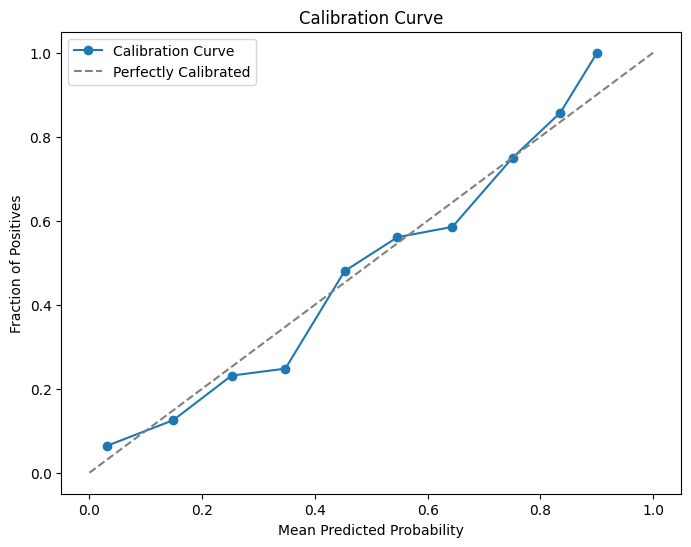

In [34]:
# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_test_prob, n_bins=10)
# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

(array([539., 162., 150., 110.,  87., 100.,  90.,  64.,  82.,  25.]),
 array([0.00824601, 0.09755859, 0.18687116, 0.27618374, 0.36549631,
        0.45480888, 0.54412146, 0.63343403, 0.72274661, 0.81205918,
        0.90137175]),
 <BarContainer object of 10 artists>)

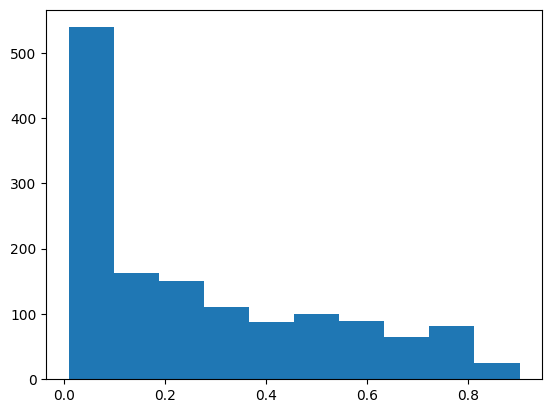

In [35]:
plt.hist(y_test_prob, bins=10)


In [36]:
from sklearn.calibration import CalibratedClassifierCV

# using grid search CV to identify optimal parameter serring for the calibrated classifier 

# wrap the model
calibrated = CalibratedClassifierCV(nn_tuned)


# define grid
param_grid = dict(cv=[2,3], method=['sigmoid','isotonic']) 

# define grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_log_loss')
# execute the grid search
grid_result = grid.fit(X_train_fs, y_train)

In [37]:

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.415754 using {'cv': 3, 'method': 'isotonic'}
-0.425748 (0.003167) with: {'cv': 2, 'method': 'sigmoid'}
-0.422086 (0.002765) with: {'cv': 2, 'method': 'isotonic'}
-0.426248 (0.002378) with: {'cv': 3, 'method': 'sigmoid'}
-0.415754 (0.003008) with: {'cv': 3, 'method': 'isotonic'}


Training Data Log Loss 0.40028454159717225
Test Data Log Loss 0.43165746645058606


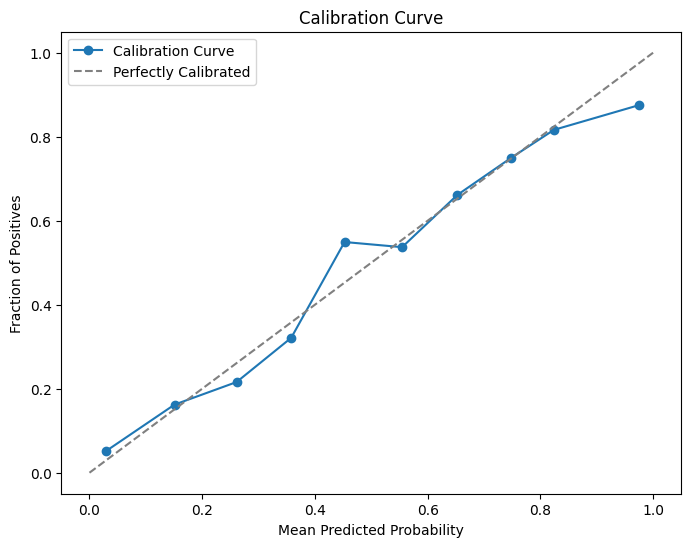

In [38]:
#check calibration curve now 
best_calibrated = CalibratedClassifierCV(nn_tuned, method='isotonic', cv=3)
# Train a Random Forest classifier

best_calibrated.fit(X_train_fs, y_train)

# Predict probabilities on the training set
y_train_prob = best_calibrated.predict_proba(X_train_fs)[:, 1]


print(f'Training Data Log Loss {m.log_loss(y_train, y_train_prob)}')

y_test_prob = best_calibrated.predict_proba(X_test_fs)[:, 1]

print(f'Test Data Log Loss {m.log_loss(y_test, y_test_prob)}') 

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_test_prob, n_bins=10)
# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()
#plot probability distribution of actual vs predicted probability 


(array([517., 222., 176., 137.,  71., 108.,  65.,  56.,  49.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

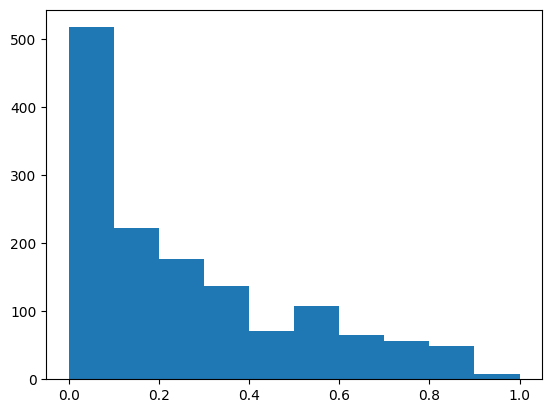

In [39]:
#plot distribution of predicted probabilities 
plt.hist(y_test_prob, bins=10)

Calibration did recude the log loss which is indicating model improvement in predicting probability

In [40]:
# #conducting SMOTE to improve model performance 
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_fs, y_train)
# # wrap the model
# calibrated = CalibratedClassifierCV(nn)


# # define grid
# param_grid = dict(cv=[2,3,4], method=['sigmoid','isotonic']) 

# # define grid search
# grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_log_loss')
# # execute the grid search
# grid_result = grid.fit(X_train_smote, y_train_smote)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [41]:
#without using RFE do cross val on training - each fold pict top 40% important features 
#then combine results by creating final list of features (include features apprearing at least in one fold)
# custome code

In [42]:
# # -- another approach 
# # -- create pipeline one hot encode -  rf estimator 
# # -- start cross val 4 fold loop - in each fold run pipeline get selected features 

# fs_model_pipeline_2 = Pipeline(steps=[
#     ('preprocessor', FS_preprocessor),
#     ('classifier', rfecv)
# ])

# scv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# # Set to hold selected features from each fold
# # -- set because I only want features found in rfecv of each fold (intersection features)
# # selected_features = set()
# feature_names = fs_model_pipeline_2.named_steps['preprocessor'].get_feature_names_out()
# feature_counter = {feature: 0 for feature in feature_names}
# # feature_counter


In [43]:
# # Cross-validation loop
# for train_index, val_index in scv.split(X_train, y_train):
# #     print(train_index[:10])
#     X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     fs_model_pipeline_2.fit(X_fold_train, y_fold_train)
#     print("Optimal number of features: %d" % rfecv.n_features_)
    
#     feature_names = fs_model_pipeline_2.named_steps['preprocessor'].get_feature_names_out()
#     print("Feature names:", feature_names.shape)

#     print("Best features: %s" % feature_names[rfecv.support_].tolist())
    
#     best_features = feature_names[rfecv.support_].tolist()
#     # Add these features to the selected_features set
        
#     # Update the feature counter dictionary
#     for feature in best_features:
#         feature_counter[feature] += 1

# # Print the final list of selected features
# print("Selected features:", selected_features)